In [1]:
import cv2
from ultralytics import YOLO
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load models
models = {
    "yolov8n": YOLO("/Users/macbook/Pengujian/videos_models/yolov8n.pt"),
    "yolov8s": YOLO("/Users/macbook/Pengujian/videos_models/yolov8s.pt"),
    "yolov8m": YOLO("/Users/macbook/Pengujian/videos_models/yolov8m.pt"),
    "yolov8l": YOLO("/Users/macbook/Pengujian/videos_models/yolov8l.pt"),
    "yolov8x": YOLO("/Users/macbook/Pengujian/videos_models/yolov8x.pt"),
}
mask = cv2.imread("/Users/macbook/Pengujian/datasets_test/mask.jpg", cv2.IMREAD_GRAYSCALE)

In [10]:
# Class names for YOLOv8 model (adjust according to your model's classes)
class_names = {0: "car", 1: "motorcycle", 2: "person"}

# Function to draw bounding boxes with different colors for each class
def draw_boxes(result, frame):
    blank = np.zeros(frame.shape, dtype=np.uint8)
    image = frame.copy()
    for box in result.boxes:
        x1, y1, x2, y2 = [round(x) for x in box.xyxy[0].tolist()]
        conf = box.conf[0]  # Confidence score
        cls = int(box.cls[0])  # Class label
        
        # Assign colors based on class
        if cls == 0:  # car
            color = (0, 255, 0)  # Green
        elif cls == 1:  # motorcycle
            color = (0, 0, 255)  # Red
        elif cls == 2:  # person
            color = (255, 0, 0)  # Blue
        else:
            color = (255, 255, 255)  # Default to white if class not recognized
        
        label = f"{class_names.get(cls, 'unknown')}: {conf:.2f}"
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.rectangle(blank, (x1, y1), (x2, y2), (255, 255, 255), -1)
    blank = cv2.bitwise_and(blank, blank, mask=mask)
    blank = cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY)
    return blank, image

# Detection function
def detect(frame, model, threshold=30):
    masked = cv2.bitwise_and(frame, frame, mask=mask)
    result = model(masked, conf=0.25, verbose=False)
    area, image = draw_boxes(result[0], frame)
    percentage = round((np.sum(area) / np.sum(mask)) * 100, 2)
    label = "ramai" if percentage > threshold else "tidak ramai"
    return area, percentage, label, image, result[0].boxes

# Video processing function
def process_video(video_path, models, threshold=30, log_path="log_data.csv"):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    start_time = time.time()

    # Dictionary to store FPS data for each model
    fps_data = {model_name: [] for model_name in models.keys()}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        for model_name, model in models.items():
            start_time = time.time()
            area, percentage, kondisi, processed_frame, boxes = detect(frame, model, threshold)
            elapsed_time = time.time() - start_time

            # Log FPS data
            fps = 1 / elapsed_time
            fps_data[model_name].append(fps)

            # Overlay text information on frame
            cv2.rectangle(processed_frame, (0, 0), (200, 60), (0, 0, 0), -1)
            cv2.putText(processed_frame, f"Area: {percentage}%", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.putText(processed_frame, f"FPS: {fps:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.putText(processed_frame, f"Kondisi: {kondisi}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

            # Save or display frame if needed (currently commented out)
            # out.write(processed_frame)
            # cv2.imshow("Video", processed_frame)
            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #     break

    cap.release()
    # out.release()  # Uncomment if using video output
    cv2.destroyAllWindows()

    # Save FPS data to CSV
    fps_df = pd.DataFrame(fps_data)
    fps_df.to_csv(log_path, index=False)

    return fps_df

In [11]:
# Run the video processing function on your video file and models
video_path = "/Users/macbook/Pengujian/videos/videos.mp4"
fps_df = process_video(video_path, models, threshold=30, log_path="/Users/macbook/Pengujian/videos_result/fps_data.csv")

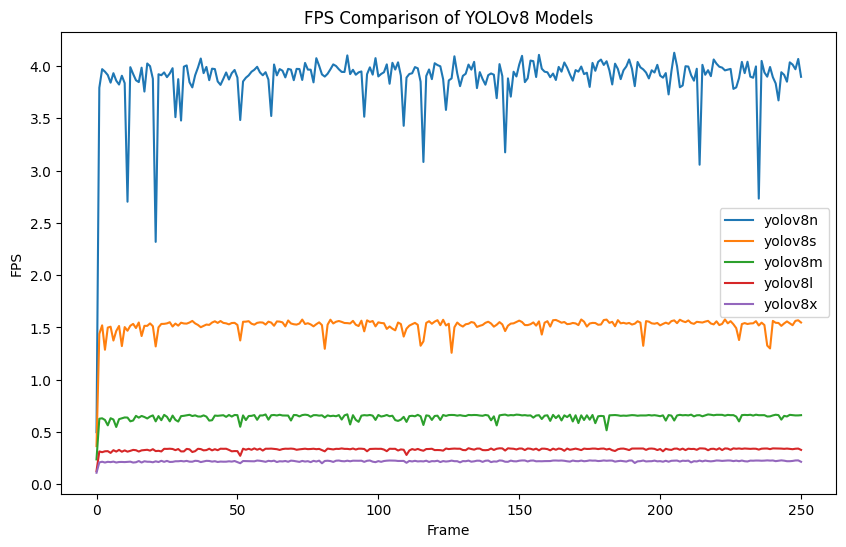

In [12]:
# Plot the FPS comparison
plt.figure(figsize=(10, 6))
for model_name in models.keys():
    plt.plot(fps_df[model_name], label=model_name)
plt.xlabel("Frame")
plt.ylabel("FPS")
plt.title("FPS Comparison of YOLOv8 Models")
plt.legend()
plt.show()